# TODO


In [2]:
#과제
#State와 결과값을 각기 유지

# Settings

In [ ]:
# %pip install -q -U langchain langchain_community langchain_core langchain_openai faiss-cpu langchain_anthropic langgraph langchain_google_community langchain_google_vertexai langchain-google-genai

In [1]:
#수집할 아티스트 데이터
we_art_name = 'FROMIS_9'

## LLM 생성

In [ ]:
# %pip install --quiet --upgrade google-cloud-aiplatform

In [10]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
import re

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

import faiss
from langchain_openai import OpenAIEmbeddings
from langchain_google_vertexai import VertexAIEmbeddings
from langchain_google_community import BigQueryVectorStore
from langchain_google_community.bigquery import BigQueryLoader
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore

import vertexai

In [11]:
from langchain_anthropic import ChatAnthropic
from langchain_google_vertexai import ChatVertexAI
from langchain_openai import ChatOpenAI
from langchain_core.runnables import ConfigurableField
import os

In [16]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain.schema import SystemMessage, HumanMessage, AIMessage
from langchain_core.output_parsers import JsonOutputParser
from pydantic  import BaseModel, Field
from operator import itemgetter

from time import time

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from pydantic import BaseModel, Field

In [12]:
#API KEY 셋팅
if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

if not os.environ.get("GOOGLE_API_KEY"):
    os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

#LLM 모델 생성 with Config

llm = (
    ChatAnthropic(model_name='claude-3-5-sonnet-20240620')
    .configurable_alternatives(
        ConfigurableField(
            id = 'llm',
            name="LLM Model",
            description="The base LLM model",
        ),
        default_key="claude3_5_sonnet",
        claude3_haiku=ChatAnthropic(model_name='claude-3-haiku-20240307'),
        gpt4o_mini = ChatOpenAI(model = 'gpt-4o-mini'),
        gpt3_5 = ChatOpenAI(model = 'gpt-3.5-turbo'),
        gemini_flash = ChatVertexAI(model="gemini-1.5-flash-001")
    )
    .configurable_fields(
        temperature=ConfigurableField(
            id="temperature",
            name="LLM Temperature",
            description="The temperature of the LLM",
        ),
        max_tokens = ConfigurableField(
            id="max_token",
            name="Maximum input Tokens",
            description="Maximum limit of input Tokens",
        ),
    )
)

## LangSmith 셋팅

In [13]:
os.environ['LANGCHAIN_API_KEY'] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

# 위키문서 로드 & 벡터스토어 생성

In [15]:
#저장된 문서 불러오기
PROJECT_ID = "wev-dev-analytics"
REGION = "asia-northeast3"
DATASET_ID = "namu_wiki"
TABLE_ID = "artists"

vertexai.init(project=PROJECT_ID, location=REGION)

# OpenAI의 "text-embedding-3-large" 모델을 사용하여 1024차원의 임베딩을 생성하는 객체를 초기화합니다.
# embeddings_docs = OpenAIEmbeddings(model="text-embedding-3-small", dimensions=1024, api_key = os.environ["OPENAI_API_KEY"])
embeddings_docs = VertexAIEmbeddings(model_name="text-multilingual-embedding-002")


#임베딩할 문서 로더
bigquery_loader = BigQueryLoader(
    query=f"""
        SELECT *
             , json_value(metadata, '$.parent_page_toc_item') as parent_paper
        FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
        WHERE artist_info = "{we_art_name}"
    """,
    project=PROJECT_ID,
    page_content_columns = "page_content", #벡터화할 텍스트 지정
    metadata_columns  = ["artist_info","toc_item","abs_page_toc_item","parent_paper","page_url"] #메타데이터 지정
)

documents = bigquery_loader.load()

#Splitter 생성
text_splitter = RecursiveCharacterTextSplitter(
  # 나무위키 한 문단에 적절하다고 판단하는 청크 사이즈
  chunk_size=700,
  # 적절하다고 생각하는 overlap
  chunk_overlap=150,
  # 문자열 길이를 계산하는 함수를 지정합니다.
  length_function=len,
  # 구분자로 정규식을 사용할지 여부를 설정합니다.
  is_separator_regex=False,
)

book = []

# metadata를 page_content에 포함시키는 함수
def concatenate_metadata_into_content(doc):
    doc.page_content = f"{doc.metadata['abs_page_toc_item']}\n\n"+re.sub('page_content:', '', f"{doc.page_content}")
    return doc

#Chunking with abs_page_toc_item
for element in documents:
  # text_splitter를 사용하여 텍스트를 문서로 분할합니다.
  papers = text_splitter.create_documents(texts = [element.page_content], metadatas = [element.metadata])
  #papers.page_content 앞에 element.metadata[abs_page_toc_item] concat하기
  book.extend(list(map(concatenate_metadata_into_content, papers)))


#FAISS 벡터스토어 생성
index = faiss.IndexFlatL2(len(embeddings_docs.embed(texts = ["hello world"], embeddings_task_type = 'RETRIEVAL_DOCUMENT')))

##Sementic Search를 위한 Chunking 문서 임베딩
vstr = FAISS(
    embedding_function=embeddings_docs,
    index=index,
    docstore= InMemoryDocstore(),
    index_to_docstore_id={}
)

# Convert documents to embeddings and store them
# vstr.add_documents(documents=book)

In [17]:
def get_chain(model, retriever = None, parser = StrOutputParser()):
    # 시스템 프롬프트 설정
    system_prompt = SystemMessagePromptTemplate.from_template(
        """
        You are a biographical dictionary agent. Your sole purpose is to provide factual information based strictly on the provided <Context>.

        - **Behavior:**
          - Be friendly and helpful without being overly chatty.
          - Do not use any prior knowledge beyond the <Context>.
          - If the answer cannot be found within the <Context>, respond with "None"

        - **Input Structure:**
          - The input will be provided using the following tags:
            ```
            <Context>
            ...
            </Context>
            <Question>
            ...
            </Question>
            <Format>
            ...
            </Format>
            ```

        - **Response Guidelines:**
          - **Do not** include the `<Context>`, `<Question>`, or `<Format>` tags in your response.
          - **Only** provide the answer as specified in the `<Format>` section.
          - Ensure the response strictly adheres to the format provided.
        """
    )

    # Runnable로 채워질 부분
    human_prompt = HumanMessagePromptTemplate.from_template(
        """<Context>{context}</Context>\n\n
        <Question>{question}</Question>\n\n
        <Format>{format_instructions}</Format>"""
    )
    prompt = ChatPromptTemplate.from_messages([system_prompt, human_prompt])
    if isinstance(parser, JsonOutputParser):
      prompt = prompt.partial(format_instructions=parser.get_format_instructions())

    def concat_docs(docs) -> str: # retriever가 반환한 모든 Document들의 page_content를 하나의 단일 string으로 붙여주는 함수
        return "".join(doc.page_content for doc in docs)

    chain = {}

    # 기본 메타데이터는 리트리버 사용하지 않고 지정된 문서를 Context로 전달
    if retriever is None:
      chain = {
            'context': itemgetter('context') | RunnablePassthrough()
          , 'question': itemgetter('question') | RunnablePassthrough()
      } | prompt | model | parser
    else:
      chain = {
            "context" : itemgetter('question') | retriever | concat_docs
          , "question" : itemgetter('question') | RunnablePassthrough()
      } | prompt| model | parser

    return chain

# 질문 Set

In [18]:
# 지시: Answer the question
# 형식: JsonOutputParser
# 맥락: context (documents or retriever)
# 역할: SystemPrompt

# 원하는 데이터 구조를 정의합니다.
class Ctry(BaseModel):
    ctry: list = Field(description="ISO 3166-1 alpha-2 형식, 최소 1개 이상")

class Gender(BaseModel):
    gender: str = Field(description="남성과 관련된 단어가 나오면 '남성'으로, 여성과 관련된 단어가 나오면 '여성'으로 출력")

class Genre(BaseModel):
    genre: list = Field(description="문서 내 순서를 따르고, 모든 장르를 출력")

class Label(BaseModel):
    label_name: list = Field(description="고유명사만 출력하고 **괄호와 괄호 안의 내용은 반드시 제거**, 2개 이상인 경우 솔로 활동을 앞 순서에, 그룹 활동은 뒷 순서에 배치해주세요.")

class Debut(BaseModel):
    debut_date: str = Field(description="'yyyy-MM-dd' 형식으로 출력")

class MemberInfo(BaseModel):
    member_list: list = Field(description="문서 내 순서를 따른다.")

class MemberNumber(BaseModel):
    member_cnt: int = Field(description="숫자로만 출력하세요.")

class Fandom(BaseModel):
    fandom_name: str = Field(description="고유명사만 출력하고, 반복되는 문자열은 하나로 합쳐주세요.")


# 컬럼명 & 컬럼용 질문 Dict 생성
singer_queries = {
    "ctry":{
        "question":"활동 국가는?",
        "format":JsonOutputParser(pydantic_object=Ctry),
      }, #???
    "gender":{"question":"인물의 성별을 유추하세요. (힌트: 보이그룹, 걸그룹, 혼성듀오, 형, 누나, 오빠)",
              "format":JsonOutputParser(pydantic_object=Gender),
              "loc":"개요" #(솔로)PROFILE > 가족 or (그룹)개요
    },
    "genre": {"question":"음악 장르는?",
              # "format":"가장 관련성이 큰 장르 2개로 정리해줘. [장르 A, 장르 B]와 같이 쉼표로 구분된 한 줄로 출력하세요.",
              "format":JsonOutputParser(pydantic_object=Genre),
              "loc":"PROFILE" #PROFILE > 장르
    },
    "label_name": {"question":"엔터테인먼트 회사명은?",
                   "format":JsonOutputParser(pydantic_object=Label),
                   "loc":"PROFILE" #PROFILE > 소속사
    },
    "debut_date": {"question":"데뷔일자는?",
                   "format":JsonOutputParser(pydantic_object=Debut),
                   "loc":"PROFILE" #PROFILE > 데뷔일
    },
    "member_list": {"question":"문서에서 사람 이름을 모두 나열해주세요",
                    "format":JsonOutputParser(pydantic_object=MemberInfo),
                    "loc":"멤버" #멤버
    },
    "member_num": {"question":"문서에서 사람은 총 몇 명인가요?",
                   "format":JsonOutputParser(pydantic_object=MemberNumber),
                   "loc":"멤버" #멤버
    },
    "fandom_name": {"question":"팬덤명은?",
                    "format":JsonOutputParser(pydantic_object=Fandom),
                    "loc":"PROFILE" #PROFILE > 팬덤
    }
}

# Tool 정의

In [19]:
#툴은 크게 4개
#0. 전달받은 문서에서 메타데이터를 생성하는 툴
#1. 프로필에서 메타데이터 생성
## 1.1. 0.에 프로필을 전달
#2. 개요/멤버/팬덤 문서에서 메타데이터 생성
## 2.1. 0.에 개요/멤버/팬덤을 각각 전달
## 2.2. 2.1.에서 생성한 3개의 df를 머지
#3. 리트리버에서 메타데이터 생성
## 3.1. 흠...
#4. 1~3의 결과를 종합해서 최종 데이터를 만드는 툴

#나중에는...
#아티스트명을 입력받아서 이 아티스트가 가수/배우/그 외에 따라서 질문 set을 다르게 가져와야함.

## 전달받은 문서에서 메타데이터를 생성하는 툴

In [20]:
import re
import pandas as pd

def answer_to_df(q_dict, docs):

    answer_list = []

    for key, val in q_dict.items():
        #Chain 생성
        rag_chain = get_chain(model = llm, parser = val['format'])
        rag_chain = rag_chain.with_config(configurable={
            # "llm": "gpt4o_mini", #model_name,
            "llm":"gemini_flash",
            "temparature": 0, #temp,
            "max_tokens": None #max_tokens
        })

        answer = rag_chain.invoke({"question": val['question'], "context":docs})
        answer_list.append(answer)

    # 각 딕셔너리 병합
    merged_dict = {}
    for item in answer_list:
        merged_dict.update(item)

    # 병합된 딕셔너리를 DataFrame으로 변환
    result = pd.DataFrame([merged_dict])
    # print(result)

    return result

## 지정된 문서 원문에서 메타데이터를 생성하는 Tool

In [21]:
def df_from_origin(q_dict, origin):
    try:
      #RunnableParellel로 변경할 부분
      df = answer_to_df(q_dict, "\n\n".join([doc.page_content for doc in documents if doc.metadata['abs_page_toc_item'] == origin]))
    except Exception as e:
      #에러가 발생하는 경우 빈 데이터프레임을 반환
      print(e)
      df = pd.DataFrame(columns = ['ctry','gender','genre','label_name','debut_date','member_list','member_num','fandom_name'])
    finally:
      return df

## 리트리빙해서 메타데이터를 생성하는 Tool

In [24]:
# 패키지 업데이트
# %pip install -qU langchain-teddynote

Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [1 lines of output]
      ERROR: Can not execute `setup.py` since setuptools is not available in the build environment.
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
#단순 리트리빙이 아니라, 요약을 하던지, 리랭크를 하던지 해야함

In [ ]:
# 문서를 예쁘게 출력하기 위한 도우미 함수
def pretty_print_docs(docs):
    print(
        f"\n{'-' * 100}\n".join(
            [f"문서 {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]
        )
    )

In [30]:
ret = vstr.as_retriever()

In [ ]:
# 쿼리에 질문을 정의하고 관련 문서를 검색합니다.
docs = ret.invoke("노지선의 나이는?")

# 검색된 문서를 예쁘게 출력합니다.
pretty_print_docs(docs)

In [ ]:
from langchain_teddynote.document_compressors import LLMChainExtractor
from langchain.retrievers import ContextualCompressionRetriever

# from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(temperature=0, model="gpt-4o-mini")  # OpenAI 언어 모델 초기화

# LLM을 사용하여 문서 압축기 생성
compressor = LLMChainExtractor.from_llm(llm)
compression_retriever = ContextualCompressionRetriever(
    # 문서 압축기와 리트리버를 사용하여 컨텍스트 압축 리트리버 생성
    base_compressor=compressor,
    base_retriever=ret,
)

pretty_print_docs(ret.invoke("노지선의 나이는?"))

print("=========================================================")
print("============== LLMChainExtractor 적용 후 ==================")

compressed_docs = (
    compression_retriever.invoke(  # 컨텍스트 압축 리트리버를 사용하여 관련 문서 검색
        "노지선의 나이는?"
    )
)
pretty_print_docs(compressed_docs)  # 검색된 문서를 예쁘게 출력


In [ ]:
from langchain_teddynote.document_compressors import LLMChainFilter

# LLM을 사용하여 LLMChainFilter 객체를 생성합니다.
_filter = LLMChainFilter.from_llm(llm)

compression_retriever = ContextualCompressionRetriever(
    # LLMChainFilter와 retriever를 사용하여 ContextualCompressionRetriever 객체를 생성합니다.
    base_compressor=_filter,
    base_retriever=ret,
)

compressed_docs = compression_retriever.invoke(
    # 쿼리
    "노지선의 나이는?"
)
pretty_print_docs(compressed_docs)  # 압축된 문서를 예쁘게 출력합니다.


In [ ]:
from langchain.retrievers.document_compressors import EmbeddingsFilter
from langchain_openai import OpenAIEmbeddings

# 유사도 임계값이 0.76인 EmbeddingsFilter 객체를 생성합니다.
embeddings_filter = EmbeddingsFilter(embeddings=embeddings_docs, similarity_threshold=0.3)

# 기본 압축기로 embeddings_filter를, 기본 검색기로 retriever를 사용하여 ContextualCompressionRetriever 객체를 생성합니다.
compression_retriever = ContextualCompressionRetriever(
    base_compressor=embeddings_filter, base_retriever=ret
)

# ContextualCompressionRetriever 객체를 사용하여 관련 문서를 검색합니다.
compressed_docs = compression_retriever.invoke(
    # 쿼리
    "노지선의 나이는?"
)
# 압축된 문서를 예쁘게 출력합니다.
pretty_print_docs(compressed_docs)


In [ ]:
from langchain.retrievers.document_compressors import DocumentCompressorPipeline, EmbeddingsFilter
from langchain_community.document_transformers import EmbeddingsRedundantFilter
from langchain_text_splitters import CharacterTextSplitter

# 문자 기반 텍스트 분할기를 생성하고, 청크 크기를 300으로, 청크 간 중복을 0으로 설정합니다.
splitter = CharacterTextSplitter(chunk_size=300, chunk_overlap=0)

# 임베딩을 사용하여 중복 필터를 생성합니다.
redundant_filter = EmbeddingsRedundantFilter(embeddings=embeddings_docs)

# 임베딩을 사용하여 관련성 필터를 생성하고, 유사도 임계값을 0.86으로 설정합니다.
relevant_filter = EmbeddingsFilter(embeddings=embeddings_docs, similarity_threshold=0.3)

pipeline_compressor = DocumentCompressorPipeline(
    # 문서 압축 파이프라인을 생성하고, 분할기, 중복 필터, 관련성 필터, LLMChainExtractor를 변환기로 설정합니다.
    transformers=[
        splitter,
        redundant_filter,
        relevant_filter,
        LLMChainExtractor.from_llm(llm),
    ]
)
compression_retriever = ContextualCompressionRetriever(
    # 기본 압축기로 pipeline_compressor를 사용하고, 기본 검색기로 retriever를 사용하여 ContextualCompressionRetriever를 초기화합니다.
    base_compressor=pipeline_compressor,
    base_retriever=ret,
)

compressed_docs = compression_retriever.invoke(
    # 쿼리
    "노지선의 나이는?"
)
# 압축된 문서를 예쁘게 출력합니다.
pretty_print_docs(compressed_docs)


In [ ]:
chain = itemgetter('question') | ret | concat_docs

In [ ]:
chain.invoke({'question':'음악 장르는?'})

In [ ]:
result

In [ ]:
type(result)

In [ ]:
def df_from_retriever(q_dict):
  ret = vstr.as_retriever()

In [ ]:
df = df_from_origin(singer_queries, '개요')

In [ ]:
df

# Agent 생성

In [ ]:
#Workflow
##1. (미구현) 아티스트의 성격 분류 / 가수(현재 구현 ver), 배우, 셀럽
##2. 총 5개 (프로필 / 개요 / 멤버 / 팬덤 + 전체 문서 리트리빙)의 툴을 실행
##2.1. 각 결과값으로 pandas dataframe을 생성
##2.2. 프로필 / 개요 / 멤버 / 팬덤은 Map-reduce 적용 검토
##3. 5개 문서 결과값에 대해 가중치를 적용해서 dataframe merge

In [27]:
llm = llm.with_config(configurable={
            # "llm": "gpt4o_mini", #model_name,
            "llm":"gemini_flash",
            "temparature": 0, #temp,
            "max_tokens": None #max_tokens
        })

In [29]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
import operator
from typing import Annotated
from langgraph.graph import MessagesState

class ArtistMeta(TypedDict):
    ctry: list #= Field(description="ISO 3166-1 alpha-2 형식, 최소 1개 이상")
    gender: str #= Field(description="남성과 관련된 단어가 나오면 '남성'으로, 여성과 관련된 단어가 나오면 '여성'으로 출력")
    genre: list #= Field(description="문서 내 순서를 따르고, 모든 장르를 출력")
    label_name: list #= Field(description="고유명사만 출력하고 **괄호와 괄호 안의 내용은 반드시 제거**, 2개 이상인 경우 솔로 활동을 앞 순서에, 그룹 활동은 뒷 순서에 배치해주세요.")
    debut_date: str #= Field(description="'yyyy-MM-dd' 형식으로 출력")
    member_list: list #= Field(description="문서 내 순서를 따른다.")
    member_cnt: int #= Field(description="숫자로만 출력하세요.")
    fandom_name: str #= Field(description="고유명사만 출력하고, 반복되는 문자열은 하나로 합쳐주세요.")

class ArtistState(TypedDict):
    qnf: dict #= Field(description="아티스트에 대한 특정 질문")
    doc: str #= Field(description="아티스트 데이터를 찾아볼 문서")
    meta: Annotated[List[dict], operator.add]

In [30]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

def answer_from_origin(state: ArtistState):

  question = state['qnf']['question']
  format = state['qnf']['format']
  doc = state['doc']
  meta = state['meta']

  # 시스템 프롬프트 설정
  system_prompt = SystemMessagePromptTemplate.from_template(
      """
      You are a biographical dictionary agent. Your sole purpose is to provide factual information based strictly on the provided <Context>.

      - **Behavior:**
        - Be friendly and helpful without being overly chatty.
        - Do not use any prior knowledge beyond the <Context>.
        - If the answer cannot be found within the <Context>, respond with "None"

      - **Input Structure:**
        - The input will be provided using the following tags:
          ```
          <Context>
          ...
          </Context>
          <Question>
          ...
          </Question>
          <Format>
          ...
          </Format>
          ```

      - **Response Guidelines:**
        - **Do not** include the `<Context>`, `<Question>`, or `<Format>` tags in your response.
        - **Only** provide the answer as specified in the `<Format>` section.
        - Ensure the response strictly adheres to the format provided.
      """
  )

  human_prompt = HumanMessagePromptTemplate.from_template(
      """<Context>{context}</Context>\n\n
      <Question>{question}</Question>\n\n
      <Format>{format_instructions}</Format>"""
  )
  prompt = ChatPromptTemplate.from_messages([system_prompt, human_prompt])
  if isinstance(format, JsonOutputParser):
    prompt = prompt.partial(format_instructions=format.get_format_instructions())

  chain = {
          'context': itemgetter('context') | RunnablePassthrough()
        , 'question': itemgetter('question') | RunnablePassthrough()
    } | prompt | llm | format

  answer = chain.invoke({"question": question, "context":doc})
  print(answer)

  # meta.update(answer)
  return {"meta":[answer]}

In [31]:
from langgraph.constants import Send

def init_graph(state:ArtistState):
  pass

def split_question(state:ArtistState):
  qnf = singer_queries
  doc = "\n\n".join([doc.page_content for doc in documents if doc.metadata['abs_page_toc_item'] == "PROFILE"])
  return [Send("answer_from_origin", {"qnf":qnf[key], "doc":doc, "meta": {}}) for key, value in qnf.items()]

In [52]:
#질문Set과 특정 페이지 원문이 input
#원문에 대해 질문Set의 각각을 별도로 질문
#meta에 list로 merge한 것이 output

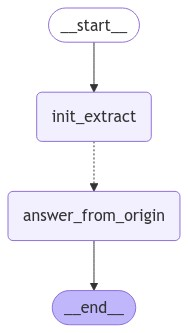

In [32]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# Add nodes and edges
builder = StateGraph(ArtistState)

#node
builder.add_node("init_extract", init_graph)
builder.add_node("answer_from_origin", answer_from_origin)

#edge
builder.add_edge(START, "init_extract")
builder.add_conditional_edges("init_extract", split_question, ["answer_from_origin"])
builder.add_edge("answer_from_origin", END)

# Compile
graph = builder.compile()

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
graph.invoke({"meta":[]})

In [ ]:
#전체 그래프
#질문Set과 documents가 input
#List[Dict]가 output / 또는 pd.Dataframe이 output

In [107]:
class PageState(TypedDict):
    page: str
    hit: str

class GraphState(TypedDict):
    questions: dict
    documents: list
    meta: List[dict]
    page_cond: Annotated[List[dict], operator.add]

In [ ]:
#check_origin
#page명, documents가 인풋
#page명, 존재를 다음 edge의 인풋으로 전달
#다음 edge는 페이지 Not Found이면 return empty dict or dataframe인 노드로 보내고 아니면 answer_from_origin으로 보냄

In [113]:
from langgraph.constants import Send

def init_graph(state:GraphState):
  # return {"meta":[]}
  pass

def split_origin_pages(state:GraphState):
  origin_pages = ["PROFILE","개요","멤버","팬덤","덕질"]
  return [Send("check_origin", {"page":p}) for p in origin_pages]

def check_origin(state:PageState):
  page = state['page']
  doc = "\n\n".join([doc.page_content for doc in documents if doc.metadata['abs_page_toc_item'] == page])
  if doc != '':
    print("page "+page+" is not None")
    return {"page_cond":[{"page":page, "hit":"Y"}]}
  else:
    print("page "+page+" is None")
    return {"page_cond":[{"page":page, "hit":"N"}]}

def split_qna(state:GraphState):
  page_cond = state['page_cond']
  
  for p in page_cond:
    if p['hit'] == 'Y':
      print(p['page'], ':Y')
    else:
      print(p['page'], ':n')

  # doc = "\n\n".join([doc.page_content for doc in documents if doc.metadata['abs_page_toc_item'] == subj])
  # return [Send("answer_from_origin", {"qnf":qnf[key], "doc":doc, "meta": {}}) for key, value in qnf.items()]

def merge_meta(state:ArtistState):
  pass

In [ ]:
for key, value in singer_queries.items():
  print(key)

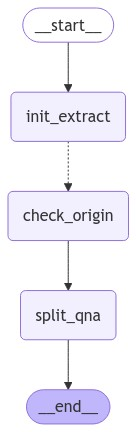

In [114]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# Add nodes and edges
builder = StateGraph(GraphState)
builder.add_node("init_extract", init_graph)
builder.add_node("check_origin", check_origin)
builder.add_node("split_qna", split_qna)
# builder.add_node("merge_meta", merge_meta)
builder.add_edge(START, "init_extract")
builder.add_conditional_edges("init_extract", split_origin_pages, ["check_origin"])
builder.add_edge("check_origin", "split_qna")
builder.add_edge("split_qna", END)

# Compile
memory = MemorySaver()
# graph = builder.compile(checkpointer=memory)
graph = builder.compile()

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [115]:
graph.invoke({"meta":{}})

page PROFILE is not None
page 개요 is not None
page 멤버 is not None
page 덕질 is None
page 팬덤 is None
PROFILE :Y
개요 :Y
멤버 :Y
팬덤 :n
덕질 :n


{'meta': {},
 'page_cond': [{'page': 'PROFILE', 'hit': 'Y'},
  {'page': '개요', 'hit': 'Y'},
  {'page': '멤버', 'hit': 'Y'},
  {'page': '팬덤', 'hit': 'N'},
  {'page': '덕질', 'hit': 'N'}]}

In [ ]:
# Input
# thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
# event = graph.invoke({"qnf":singer_queries['debut_date'], "doc":"\n\n".join([doc.page_content for doc in documents if doc.metadata['abs_page_toc_item'] == 'PROFILE']), "meta":{}})
# event = graph.invoke({"questions":singer_queries, "documents":documents, "meta":{}})

In [ ]:
from langchain_core.messages import get_buffer_string

import re
import pandas as pd


# 컬럼명 & 컬럼용 질문 Dict 생성
singer_queries = {
    "ctry":{
        "question":"활동 국가는?",
        "format":JsonOutputParser(pydantic_object=Ctry),
      }, #???
    "gender":{"question":"인물의 성별을 유추하세요. (힌트: 보이그룹, 걸그룹, 혼성듀오, 형, 누나, 오빠)",
              "format":JsonOutputParser(pydantic_object=Gender),
              "loc":"개요" #(솔로)PROFILE > 가족 or (그룹)개요
    },
    "genre": {"question":"음악 장르는?",
              # "format":"가장 관련성이 큰 장르 2개로 정리해줘. [장르 A, 장르 B]와 같이 쉼표로 구분된 한 줄로 출력하세요.",
              "format":JsonOutputParser(pydantic_object=Genre),
              "loc":"PROFILE" #PROFILE > 장르
    },
    "label_name": {"question":"엔터테인먼트 회사명은?",
                   "format":JsonOutputParser(pydantic_object=Label),
                   "loc":"PROFILE" #PROFILE > 소속사
    },
    "debut_date": {"question":"데뷔일자는?",
                   "format":JsonOutputParser(pydantic_object=Debut),
                   "loc":"PROFILE" #PROFILE > 데뷔일
    },
    "member_list": {"question":"문서에서 사람 이름을 모두 나열해주세요",
                    "format":JsonOutputParser(pydantic_object=MemberInfo),
                    "loc":"멤버" #멤버
    },
    "member_num": {"question":"문서에서 사람은 총 몇 명인가요?",
                   "format":JsonOutputParser(pydantic_object=MemberNumber),
                   "loc":"멤버" #멤버
    },
    "fandom_name": {"question":"팬덤명은?",
                    "format":JsonOutputParser(pydantic_object=Fandom),
                    "loc":"PROFILE" #PROFILE > 팬덤
    }
}



# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert.

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.

First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):

    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def search_wikipedia(state: InterviewState):

    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    # Search
    search_docs = WikipediaLoader(query=search_query.search_query,
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}.

You goal is to answer a question posed by the interviewer.

To answer question, use this context:

{context}

When answering questions, follow these guidelines:

1. Use only the information provided in the context.

2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1].

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc

6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list:

[1] assistant/docs/llama3_1.pdf, page 7

And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):

    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Name the message as coming from the expert
    answer.name = "expert"

    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):

    """ Save interviews """

    # Get messages
    messages = state["messages"]

    # Convert interview to a string
    interview = get_buffer_string(messages)

    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState,
                   name: str = "expert"):

    """ Route between question and answer """

    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]

    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer.

Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents:
- The name of each source document is at the start of the document, with the <Document tag.

2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers

3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst:
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents

6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/

8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]

    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")])

    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [ ]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic:

{topic}

You have a team of analysts. Each analyst has done two things:

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task:

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos.
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:

1. Use markdown formatting.
2. Include no pre-amble for the report.
3. Use no sub-heading.
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from:

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")])
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting.

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header.

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")])
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")])
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("write_report",write_report)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge("conduct_interview", "write_report")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

# 프롬프트 최적화

In [ ]:
# 컬럼명 & 컬럼용 질문 Dict 생성
qq = singer_queries['member_list']['question']
loc = '멤버'

# 시스템 프롬프트 설정
system_prompt = SystemMessagePromptTemplate.from_template(
    """
    You are a biographical dictionary agent. Provide only factual information based solely on the provided Context.
    Be friendly and helpful without being overly chatty. Do not use any prior knowledge beyond the Context.
    If the answer is not found in the Context, respond with "None" Follow the specified Output Format below.

    The input will be provided using the following tags:
    <Context>...</Context>
    <Question>...</Question>

    Please extract the Context, Question, and Format from these tags and answer the query accordingly.
    """
)

human_prompt = HumanMessagePromptTemplate.from_template(
    """<Context>n{context}</Context>\n\n
    <Question>{question}</Question>\n\n
    """
)
prompt = ChatPromptTemplate.from_messages([system_prompt, human_prompt])
chain = {
      'context': itemgetter('context') | RunnablePassthrough()
    , 'question': itemgetter('question') | RunnablePassthrough()
} | prompt | llm | StrOutputParser()

result = chain.with_config(configurable={
            #   "llm": 'gpt4o_mini',
            "llm":"gemini_flash",
              "temparature": 0,
              "max_tokens": None #max_tokens
          }).invoke({"question": qq, 'context': "\n\n".join([doc.page_content for doc in documents if doc.metadata['abs_page_toc_item'] == loc])})

print(result)

In [ ]:
type(chain)

In [ ]:
qq

In [ ]:
"\n\n".join([doc.page_content for doc in documents if doc.metadata['parent_paper'] == '팬덤'])